In [459]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [460]:
import numpy as np
import pandas as pd

from metric import *
from metric2 import *
import os 

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]="7"  # Set the GPUs 2 and 3 to use

import seaborn as sns
import matplotlib.pyplot as plt
def show_corr(X_org, col_names, data_name, miss_algo):
    plt.figure(figsize=(8, 6))
    temp = pd.DataFrame(X_org, columns=col_names).corr()
    sns.heatmap(temp, cmap='RdBu', square=False, annot=True, fmt='.1f', annot_kws={"size": 8}, linewidth=.5)
    plt.title(f'Correlation of Data({data_name}_{miss_algo})', size=15, weight='bold')
    plt.show()
    
pd.set_option('display.max_columns', 50)

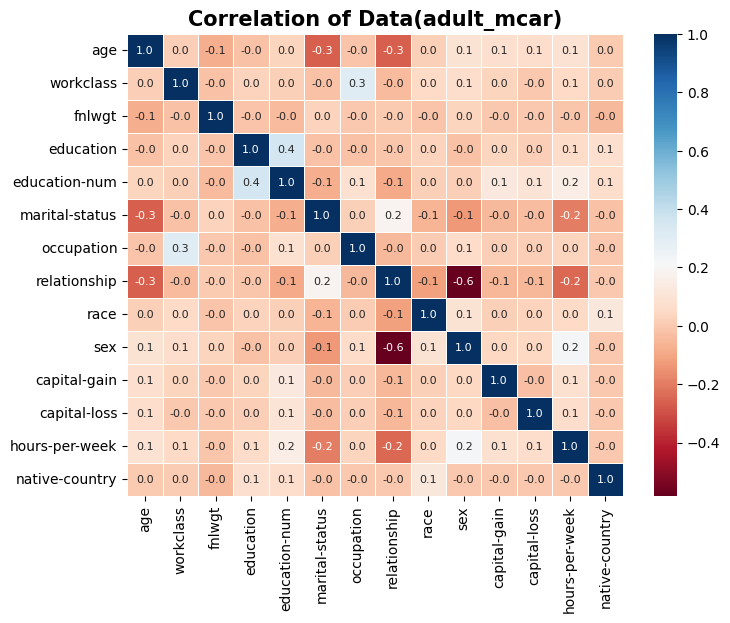

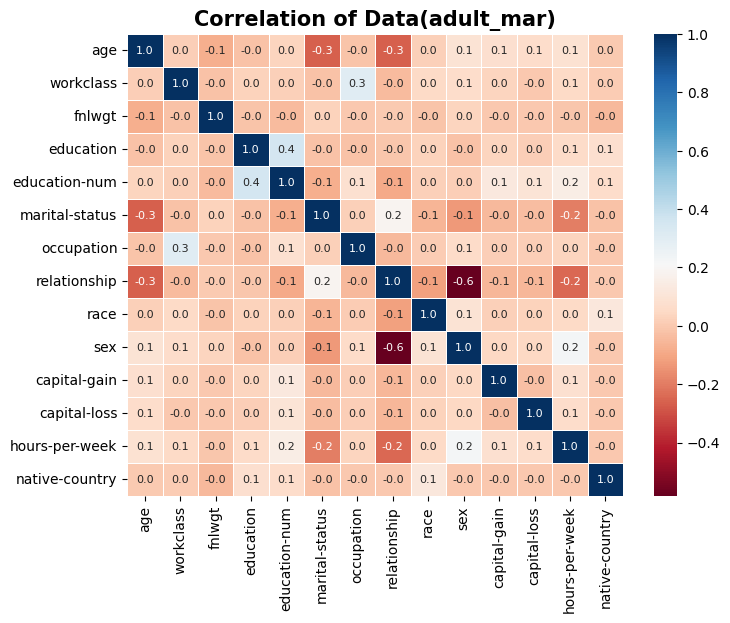

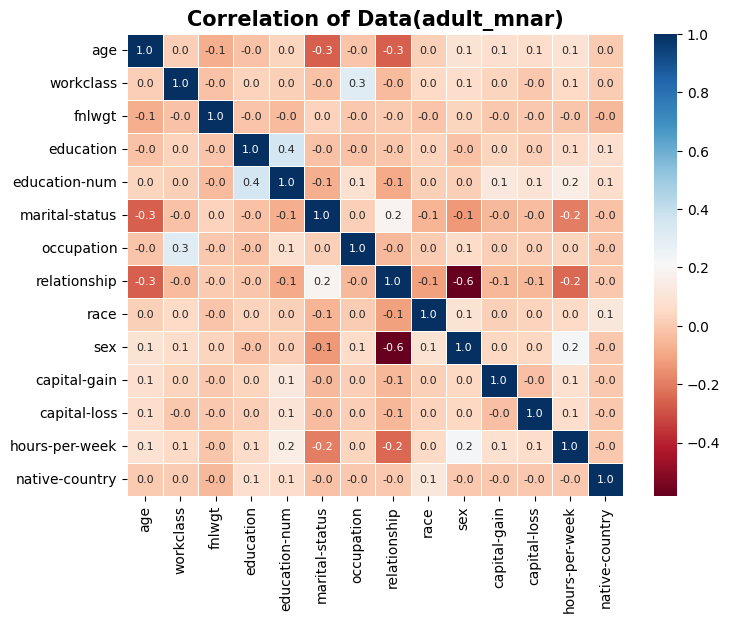

,dataset,miss_algo,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,adult,mcar,0.197139,0.201936,0.200532,0.200591,0.199421,0.199333,0.197900,0.200298,0.19828,0.199860,0.197841,0.201702,0.204539,0.20062
1,adult,mar,0.200532,0.000000,0.196964,0.202960,0.196759,0.000000,0.196847,0.199011,0.19477,0.199275,0.203136,0.000000,0.000000,0.19986
2,adult,mnar,0.200532,0.199128,0.196964,0.202960,0.196759,0.198339,0.196847,0.199011,0.19477,0.199275,0.203136,0.200269,0.203428,0.19986


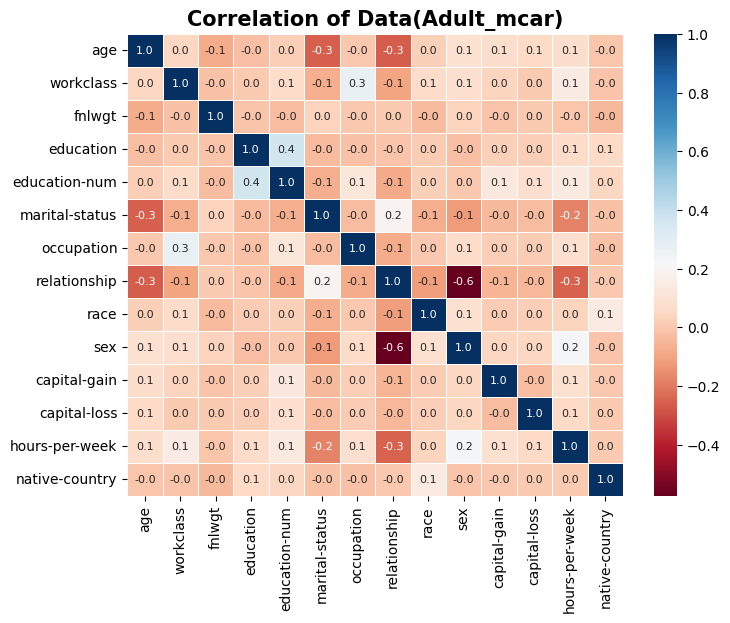

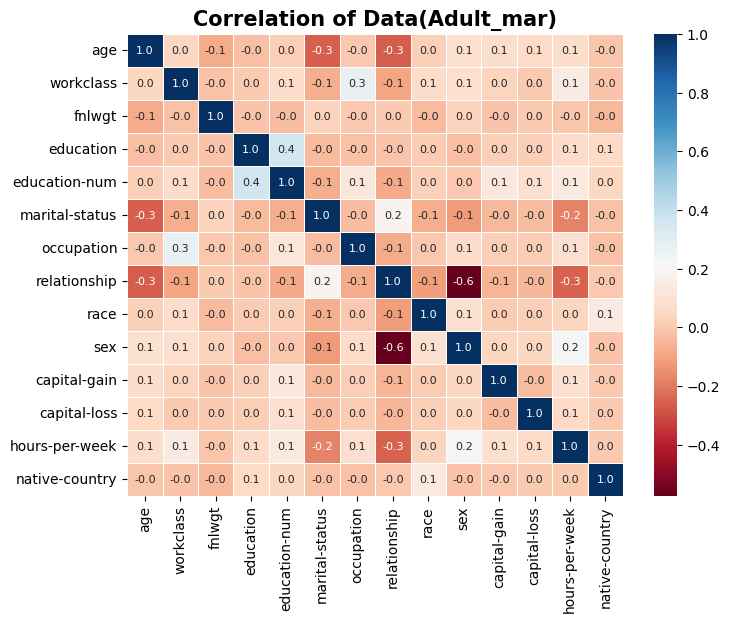

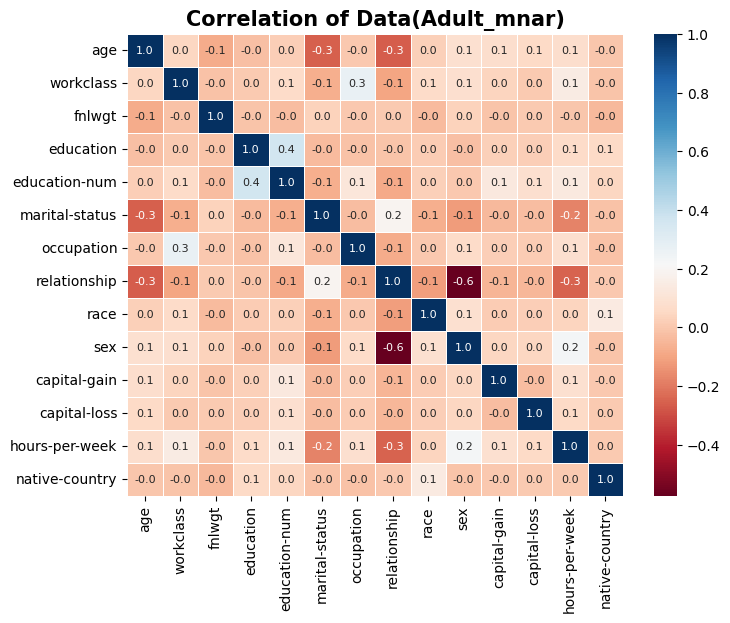

,dataset,miss_algo,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,Adult,mcar,0.198704,0.201837,0.199134,0.200516,0.201744,0.198274,0.202973,0.199717,0.195971,0.199349,0.197998,0.202174,0.199533,0.202052
1,Adult,mar,0.199564,0.000000,0.196401,0.203556,0.197046,0.000000,0.196738,0.199042,0.194619,0.201806,0.203403,0.000000,0.000000,0.199779
2,Adult,mnar,0.199564,0.196339,0.196401,0.203556,0.197046,0.196738,0.196738,0.199042,0.194619,0.201806,0.203403,0.200455,0.203126,0.199779


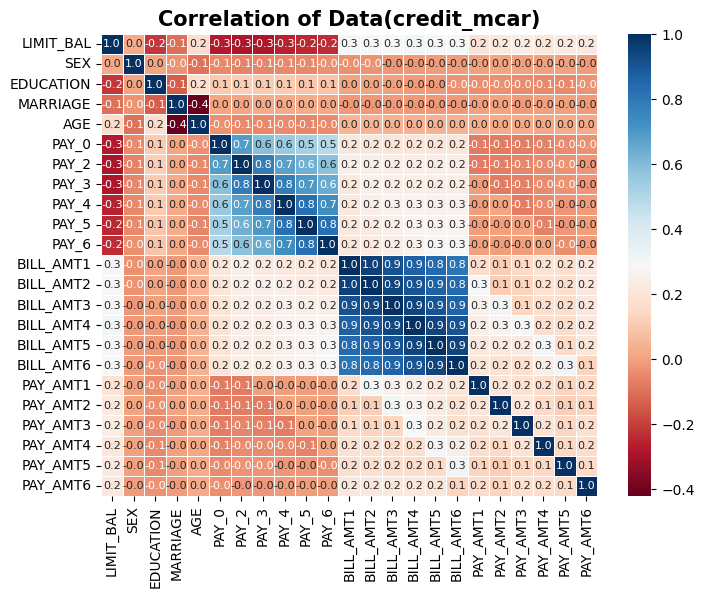

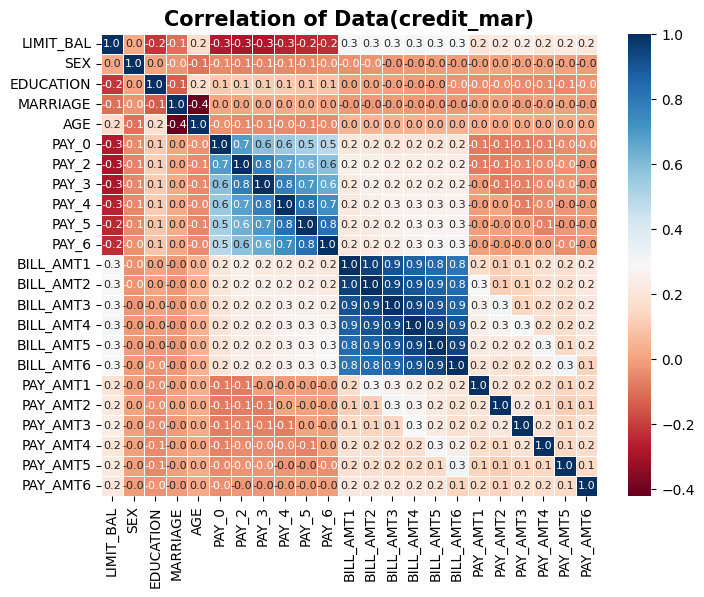

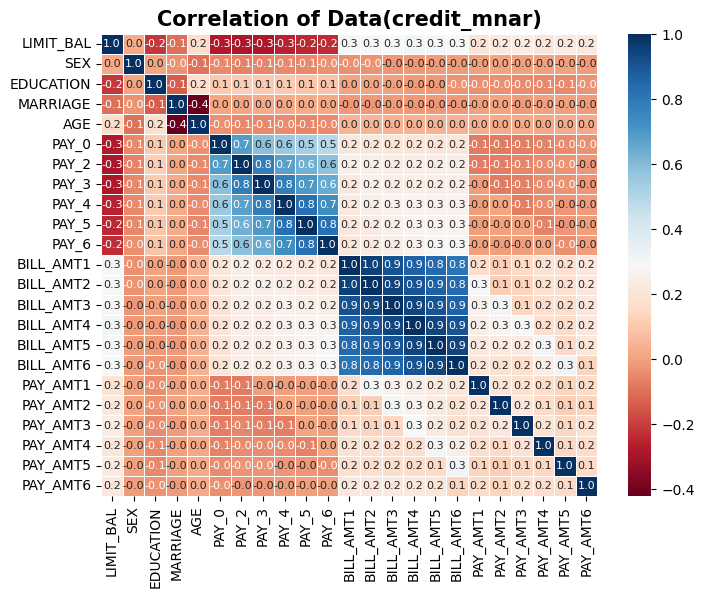

,dataset,miss_algo,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,credit,mcar,0.199333,0.197095,0.202952,0.202429,0.198476,0.204000,0.201857,0.199381,0.195048,0.201905,0.198286,0.197905,0.199905,0.200667,0.197714,0.197286,0.202286,0.206048,0.196905,0.199000,0.202381,0.198429,0.200714
1,credit,mar,0.200905,0.197571,0.195667,0.202048,0.199095,0.202429,0.000000,0.200429,0.200571,0.197619,0.201333,0.000000,0.000000,0.199810,0.193667,0.198524,0.201619,0.000000,0.200333,0.000000,0.000000,0.203095,0.195714
2,credit,mnar,0.200905,0.197571,0.195667,0.202048,0.199095,0.202429,0.200571,0.200429,0.200571,0.197619,0.201333,0.198476,0.203952,0.199810,0.193667,0.198524,0.201619,0.199476,0.200333,0.202048,0.198810,0.203095,0.195714


In [464]:
from glob import glob
miss_algos = ['mcar', 'mar', 'mnar']
data_names = ['adult', 'Adult', 'credit']
losses = [] # miss_algo -> dataset -> model -> seed -> loss -> mode(all, column)
for data_name in data_names:
    miss_df = []
    for miss_algo in miss_algos:
        raw_data = np.load(f'/home/redgreen/ssl/metric/{data_name.lower()}.npy', allow_pickle=True).item()
        col_names = raw_data['col_names']
        dataset = np.load(f'/home/redgreen/ssl/EGG_GAE/noised_datasets/{data_name}_{miss_algo}/{data_name}/{data_name}.npz', 
                          allow_pickle=True)
        # dataset = np.load(f'/home/redgreen/ssl/EGG_GAE/noised_datasets/{data_name}_{miss_algo}_us/{data_name}_us/{data_name}_us.npz', 
        #                   allow_pickle=True)
        X_org = dataset['X_test_clean']
        miss_df.append([data_name, miss_algo, *(1-dataset['mask_init_train'].mean(axis=0))])
        show_corr(X_org, col_names, data_name, miss_algo)
        mar_check = np.isclose(dataset['X_train_clean'], dataset['X_train_deg']).sum(axis=0)
        mar_check = [i for i, cnt in enumerate(mar_check) if cnt == len(dataset['X_train_clean'])]
        cat_idx = [i for i in dataset['cat_idx'] if i not in mar_check]
        num_idx = [i for i in dataset['num_idx'] if i not in mar_check]
        path_egg_gae = sorted(glob(f'egg_gae/{data_name}_{miss_algo}*'))
        path_gain = sorted(glob(f'gain/{data_name}_{miss_algo}*'))
        for i in range(5):
            X_egg_gae = np.load(path_egg_gae[i], allow_pickle=True)
            X_gain = np.load(path_gain[i], allow_pickle=True)
            # loss
            record_loss(losses, X_org, X_egg_gae, cat_idx, num_idx, col_names,
                        miss_algo, data_name, 'egg_gae', i)
            record_loss(losses, X_org, X_gain, cat_idx, num_idx, col_names,
                        miss_algo, data_name, 'gain', i)
        # path_mice = glob(f'mice/{miss_algo.upper()}_*{data_name}_mice.npy')[0]
        path_mice = glob(f'mice/{miss_algo.lower()}_*{data_name}_mice.npy') + glob(f'mice/{miss_algo.upper()}_*{data_name}_mice.npy')
        X_mice = np.load(path_mice[0], allow_pickle=True).astype(float)
        record_loss(losses, X_org, X_mice, cat_idx, num_idx, col_names,
                    miss_algo, data_name, 'mice', 0)
    display(pd.DataFrame(miss_df, columns=['dataset', 'miss_algo', *col_names]))
result_df = pd.DataFrame(losses, columns=['column', 'miss_algo', 'dataset', 'model', 'seed', 'metric', 'value'])


In [465]:
for metric in ['RMSE', 'REL', 'ACC']:
    df = result_df.query('column=="all" and metric==@metric')
    # display(df.pivot_table(index=['metric', 'miss_algo','dataset','column'], columns=['model'], values='value', aggfunc='mean', sort=False))
    pivot_mean = df.pivot_table(index=['metric', 'miss_algo','dataset','column'], columns=['model'], values='value', aggfunc='mean', sort=False)
    pivot_std = df.pivot_table(index=['metric', 'miss_algo','dataset','column'], columns=['model'], values='value', aggfunc='std', sort=False)
    pivot_std['mice'] = 0
    pivot_result = pivot_mean.round(3).astype(str)+'±'+pivot_std.round(3).astype(str)
    display(pivot_result)

model                                egg_gae         gain     mice
metric miss_algo dataset column                                   
RMSE   mcar      adult   all     0.467±0.001   0.559±0.02  0.479±0
                 Adult   all     0.443±0.003  0.564±0.046  0.448±0
                 credit  all     0.406±0.001  0.405±0.016  0.313±0
       mar       adult   all     0.449±0.001  0.548±0.016  0.453±0
                 Adult   all     0.399±0.003    0.5±0.013  0.396±0
                 credit  all     0.545±0.004  0.454±0.007   0.38±0
       mnar      adult   all     0.469±0.001  0.572±0.029  0.469±0
                 Adult   all     0.431±0.001  0.536±0.027  0.431±0
                 credit  all     0.519±0.003  0.446±0.009  0.359±0

model                                egg_gae         gain     mice
metric miss_algo dataset column                                   
REL    mcar      adult   all     0.462±0.036  0.692±0.204  0.255±0
                 Adult   all       1.352±0.7  1.734±0.694  1.097±0
                 credit  all     0.523±0.037  0.605±0.094  0.306±0
       mar       adult   all     0.356±0.053  0.555±0.158  0.338±0
                 Adult   all     0.461±0.057   0.583±0.13  0.389±0
                 credit  all     0.741±0.063  0.525±0.154  0.274±0
       mnar      adult   all     0.447±0.027   0.92±0.303  0.265±0
                 Adult   all     0.498±0.047  0.756±0.063  0.372±0
                 credit  all     0.779±0.051  0.752±0.163  0.392±0

model                                egg_gae         gain     mice
metric miss_algo dataset column                                   
ACC    mcar      adult   all     0.937±0.001  0.853±0.014  0.941±0
                 Adult   all     0.912±0.002   0.86±0.011  0.921±0
                 credit  all     0.912±0.001  0.904±0.002  0.917±0
       mar       adult   all     0.934±0.001  0.857±0.015   0.94±0
                 Adult   all     0.902±0.001  0.865±0.007  0.914±0
                 credit  all      0.91±0.001  0.903±0.002  0.919±0
       mnar      adult   all     0.935±0.001  0.852±0.021  0.941±0
                 Adult   all     0.911±0.002   0.853±0.01  0.921±0
                 credit  all      0.91±0.001  0.904±0.001  0.918±0

In [457]:
pivot_std.loc[:, ('mcar','mice')] = 0

miss_algo                        mcar            mar           mnar         \
model                         egg_gae   gain egg_gae   gain egg_gae   gain   
metric dataset column                                                        
ACC    adult   workclass        0.001  0.049   0.000  0.000   0.001  0.056   
               education        0.002  0.024   0.003  0.004   0.004  0.011   
               marital-status   0.001  0.045   0.000  0.000   0.001  0.039   
               occupation       0.001  0.009   0.001  0.001   0.002  0.007   
               relationship     0.002  0.002   0.006  0.015   0.001  0.028   
               race             0.000  0.081   0.000  0.062   0.000  0.045   
               sex              0.001  0.011   0.002  0.006   0.003  0.017   
               native-country   0.000  0.012   0.000  0.016   0.000  0.048   
       Adult   workclass        0.001  0.054   0.000  0.000   0.000  0.047   
               education        0.006  0.028   0.003  0.024   0.004  0.017   
               marital-status   0.003  0.046   0.000  0.000   0.003  0.036   
               occupation       0.003  0.008   0.002  0.001   0.002  0.002   
               relationship     0.003  0.022   0.002  0.014   0.004  0.023   
               race             0.006  0.060   0.001  0.038   0.007  0.083   
               sex              0.002  0.014   0.002  0.004   0.002  0.008   
               native-country   0.000  0.048   0.000  0.023   0.000  0.009   
       credit  SEX              0.001  0.003   0.001  0.005   0.001  0.002   
               EDUCATION        0.001  0.000   0.002  0.000   0.000  0.000   
               MARRIAGE         0.001  0.004   0.002  0.005   0.004  0.000   

miss_algo                     mice mcar  
model                              mice  
metric dataset column                    
ACC    adult   workclass         0    0  
               education         0    0  
               marital-status    0    0  
               occupation        0    0  
               relationship      0    0  
               race              0    0  
               sex               0    0  
               native-country    0    0  
       Adult   workclass         0    0  
               education         0    0  
               marital-status    0    0  
               occupation        0    0  
               relationship      0    0  
               race              0    0  
               sex               0    0  
               native-country    0    0  
       credit  SEX               0    0  
               EDUCATION         0    0  
               MARRIAGE          0    0

In [463]:
pd.set_option('display.max_rows', 100)

for metric in ['RMSE', 'REL', 'ACC']:
    print(f'[{metric}]')
    df =result_df.query('column != "all" and metric==@metric')
    pivot_mean = df.pivot_table(index=['metric', 'dataset','column'], columns=['miss_algo','model'], values='value', aggfunc='mean', sort=False, fill_value=0).round(3)
    pivot_std = df.pivot_table(index=['metric', 'dataset','column'], columns=['miss_algo','model'], values='value', aggfunc='std', sort=False, fill_value=0).round(3)
    # pivot_std['mice'] = 0
    pivot_std.loc[:, ('mcar','mice')] = 0
    pivot_std.loc[:, ('mar','mice')] = 0
    pivot_std.loc[:, ('mnar','mice')] = 0
    pivot_result = pivot_mean.round(3).astype(str)+'±'+pivot_std.round(3).astype(str)
    display(pivot_result)

[RMSE]


miss_algo                              mar                               mcar  \
model                              egg_gae         gain     mice      egg_gae   
metric dataset column                                                           
RMSE   adult   age              0.39±0.003  0.512±0.031  0.403±0  0.406±0.002   
               fnlwgt          0.479±0.003  0.518±0.057  0.486±0  0.458±0.001   
               education-num   0.235±0.007  0.516±0.053  0.196±0  0.257±0.005   
               capital-gain    0.608±0.001  0.631±0.012  0.619±0  0.614±0.003   
               capital-loss        0.0±0.0      0.0±0.0    0.0±0  0.532±0.001   
               hours-per-week      0.0±0.0      0.0±0.0    0.0±0  0.458±0.001   
       Adult   age             0.402±0.002    0.5±0.022  0.409±0  0.416±0.007   
               fnlwgt          0.511±0.002   0.537±0.02  0.517±0  0.485±0.005   
               education-num   0.259±0.018  0.514±0.041  0.214±0   0.28±0.015   
               capital-gain    0.385±0.009  0.438±0.051  0.384±0  0.489±0.002   
               capital-loss        0.0±0.0      0.0±0.0    0.0±0  0.486±0.001   
               hours-per-week      0.0±0.0      0.0±0.0    0.0±0  0.463±0.001   
       credit  LIMIT_BAL       0.589±0.016  0.527±0.021  0.409±0  0.459±0.004   
               AGE              0.46±0.003  0.497±0.003  0.467±0  0.471±0.005   
               PAY_0           0.421±0.004  0.519±0.005  0.452±0  0.389±0.004   
               PAY_2               0.0±0.0      0.0±0.0    0.0±0  0.304±0.003   
               PAY_3           0.255±0.003  0.385±0.012  0.248±0  0.281±0.004   
               PAY_4           0.316±0.005  0.423±0.014  0.281±0  0.276±0.005   
               PAY_5           0.244±0.005  0.339±0.043  0.218±0  0.271±0.002   
               PAY_6           0.288±0.007   0.355±0.02  0.282±0  0.334±0.002   
               BILL_AMT1           0.0±0.0      0.0±0.0    0.0±0  0.434±0.001   
               BILL_AMT2           0.0±0.0      0.0±0.0    0.0±0   0.46±0.003   
               BILL_AMT3       1.219±0.016  0.385±0.057  0.247±0  0.422±0.003   
               BILL_AMT4       0.336±0.014  0.172±0.009  0.083±0  0.446±0.002   
               BILL_AMT5       0.273±0.016   0.157±0.01  0.082±0  0.425±0.001   
               BILL_AMT6        0.34±0.009   0.24±0.074  0.147±0  0.441±0.003   
               PAY_AMT1            0.0±0.0      0.0±0.0    0.0±0  0.577±0.002   
               PAY_AMT2         0.58±0.003  0.574±0.021  0.366±0  0.297±0.001   
               PAY_AMT3            0.0±0.0      0.0±0.0    0.0±0  0.329±0.002   
               PAY_AMT4            0.0±0.0      0.0±0.0    0.0±0   0.38±0.001   
               PAY_AMT5        0.227±0.014  0.244±0.015  0.192±0  0.409±0.001   
               PAY_AMT6        0.967±0.007  0.933±0.007  0.948±0  0.537±0.002   

miss_algo                                                   mnar               \
model                                 gain     mice      egg_gae         gain   
metric dataset column                                                           
RMSE   adult   age             0.552±0.052   0.42±0    0.4±0.004  0.513±0.035   
               fnlwgt          0.486±0.012  0.465±0  0.478±0.001  0.562±0.052   
               education-num    0.52±0.026  0.236±0  0.226±0.008  0.536±0.023   
               capital-gain    0.635±0.001  0.629±0  0.608±0.003  0.658±0.043   
               capital-loss    0.565±0.019  0.551±0  0.541±0.006  0.523±0.067   
               hours-per-week  0.575±0.086  0.477±0  0.467±0.002  0.605±0.161   
       Adult   age             0.529±0.018  0.419±0  0.417±0.004    0.5±0.013   
               fnlwgt          0.518±0.031  0.488±0   0.51±0.002  0.566±0.035   
               education-num   0.621±0.198  0.244±0  0.251±0.016  0.506±0.016   
               capital-gain    0.515±0.007  0.503±0  0.382±0.005  0.472±0.143   
               capital-loss     0.52±0.017  0.499±0  0.504±0.008  0.603±0.136   
               hours-per-week 

[REL]


miss_algo                              mar                               mcar  \
model                              egg_gae         gain     mice      egg_gae   
metric dataset column                                                           
REL    adult   age             0.378±0.054   0.43±0.113  0.435±0  0.283±0.014   
               fnlwgt          0.445±0.054   0.903±0.68   0.82±0   0.391±0.07   
               education-num   0.316±0.051  0.724±0.461  0.078±0  0.462±0.071   
               capital-gain    0.286±0.101  0.163±0.101  0.018±0   0.266±0.07   
               capital-loss        0.0±0.0      0.0±0.0    0.0±0  0.262±0.068   
               hours-per-week      0.0±0.0      0.0±0.0    0.0±0  1.108±0.035   
       Adult   age             0.461±0.074  0.352±0.077  0.518±0  0.308±0.021   
               fnlwgt          0.748±0.121   1.09±0.531  0.957±0  5.854±4.164   
               education-num   0.312±0.096   0.472±0.27  0.059±0  0.437±0.101   
               capital-gain     0.322±0.09   0.417±0.23  0.021±0  0.265±0.059   
               capital-loss        0.0±0.0      0.0±0.0    0.0±0  0.244±0.044   
               hours-per-week      0.0±0.0      0.0±0.0    0.0±0  1.003±0.106   
       credit  LIMIT_BAL       0.346±0.014  0.299±0.059  0.395±0  0.369±0.027   
               AGE             0.462±0.038  0.277±0.033  0.557±0  0.286±0.018   
               PAY_0           5.963±1.057   2.81±1.834  1.025±0  1.356±0.177   
               PAY_2               0.0±0.0      0.0±0.0    0.0±0  0.331±0.019   
               PAY_3           0.226±0.024   0.337±0.12  0.072±0  0.265±0.029   
               PAY_4           0.256±0.016  0.218±0.093    0.1±0  0.209±0.014   
               PAY_5           0.161±0.024  0.151±0.044  0.054±0  0.185±0.009   
               PAY_6            0.16±0.022  0.146±0.043  0.087±0  0.173±0.008   
               BILL_AMT1           0.0±0.0      0.0±0.0    0.0±0  0.839±0.118   
               BILL_AMT2           0.0±0.0      0.0±0.0    0.0±0  0.604±0.091   
               BILL_AMT3       0.404±0.048  0.232±0.058  0.083±0  0.768±0.128   
               BILL_AMT4        0.372±0.06  0.201±0.049  0.063±0  0.872±0.136   
               BILL_AMT5       0.383±0.046   0.18±0.021  0.066±0   0.323±0.03   
               BILL_AMT6       0.368±0.021  0.323±0.153  0.095±0   0.48±0.085   
               PAY_AMT1            0.0±0.0      0.0±0.0    0.0±0  0.615±0.098   
               PAY_AMT2        0.429±0.146  0.697±0.324  0.357±0  0.571±0.184   
               PAY_AMT3            0.0±0.0      0.0±0.0    0.0±0  0.647±0.271   
               PAY_AMT4            0.0±0.0      0.0±0.0    0.0±0  0.827±0.147   
               PAY_AMT5        0.496±0.085  0.586±0.121  0.455±0  0.348±0.049   
               PAY_AMT6        0.346±0.041     0.89±0.2  0.429±0  0.401±0.056   

miss_algo                                                   mnar               \
model                                 gain     mice      egg_gae         gain   
metric dataset column                                                           
REL    adult   age             0.353±0.117  0.349±0  0.363±0.039  0.348±0.123   
               fnlwgt          0.791±0.162  0.519±0  0.419±0.018  1.412±0.526   
               education-num   0.731±0.425  0.118±0  0.329±0.052   0.857±0.19   
               capital-gain    0.066±0.044  0.019±0   0.315±0.08  0.265±0.213   
               capital-loss     0.302±0.06  0.011±0   0.16±0.015  0.359±0.271   
               hours-per-week  1.908±1.027  0.516±0  1.098±0.088   2.28±1.825   
       Adult   age              0.32±0.103  0.359±0  0.446±0.026   0.41±0.153   
               fnlwgt          6.371±4.978  5.602±0  0.722±0.216  1.022±0.255   
               education-num    1.016±0.94  0.091±0  0.324±0.023    0.5±0.132   
               capital-gain    0.199±0.144  0.021±0  0.274±0.061  0.432±0.486   
               capital-loss    0.333±0.182  0.009±0  0.112±0.005  0.672±0.281   
               hours-per-week 

[ACC]


miss_algo                              mar                               mcar  \
model                              egg_gae         gain     mice      egg_gae   
metric dataset column                                                           
ACC    adult   workclass           0.0±0.0      0.0±0.0    0.0±0  0.946±0.001   
               education       0.877±0.003  0.803±0.004  0.908±0  0.882±0.002   
               marital-status      0.0±0.0      0.0±0.0    0.0±0   0.95±0.001   
               occupation      0.867±0.001  0.811±0.001  0.864±0   0.87±0.001   
               relationship    0.949±0.006  0.849±0.015  0.955±0  0.935±0.002   
               race              0.971±0.0  0.918±0.062   0.97±0    0.972±0.0   
               sex             0.961±0.002  0.943±0.006  0.963±0  0.958±0.001   
               native-country    0.981±0.0   0.82±0.016  0.979±0    0.979±0.0   
       Adult   workclass           0.0±0.0      0.0±0.0    0.0±0  0.947±0.001   
               education       0.873±0.003  0.818±0.024  0.912±0  0.878±0.006   
               marital-status      0.0±0.0      0.0±0.0    0.0±0  0.948±0.003   
               occupation      0.865±0.002  0.816±0.001  0.866±0  0.862±0.003   
               relationship    0.948±0.002  0.846±0.014  0.955±0  0.934±0.003   
               race            0.972±0.001  0.947±0.038  0.972±0  0.966±0.006   
               sex             0.957±0.002  0.943±0.004  0.959±0  0.956±0.002   
               native-country    0.796±0.0  0.823±0.023   0.82±0    0.802±0.0   
       credit  SEX              0.92±0.001  0.912±0.005   0.92±0  0.921±0.001   
               EDUCATION       0.901±0.002    0.894±0.0  0.904±0  0.903±0.001   
               MARRIAGE        0.909±0.002  0.904±0.005  0.935±0  0.911±0.001   

miss_algo                                                   mnar               \
model                                 gain     mice      egg_gae         gain   
metric dataset column                                                           
ACC    adult   workclass       0.864±0.049  0.948±0  0.945±0.001  0.885±0.056   
               education       0.834±0.024  0.909±0  0.873±0.004  0.811±0.011   
               marital-status  0.843±0.045  0.956±0   0.95±0.001  0.843±0.039   
               occupation      0.821±0.009  0.868±0  0.863±0.002  0.815±0.007   
               relationship    0.851±0.002  0.939±0  0.938±0.001  0.845±0.028   
               race            0.872±0.081  0.971±0    0.971±0.0   0.86±0.045   
               sex             0.929±0.011  0.961±0  0.959±0.003   0.93±0.017   
               native-country  0.808±0.012  0.977±0    0.981±0.0  0.825±0.048   
       Adult   workclass       0.913±0.054  0.947±0    0.948±0.0  0.914±0.047   
               education        0.82±0.028  0.912±0  0.873±0.004  0.823±0.017   
               marital-status  0.854±0.046  0.953±0  0.948±0.003  0.828±0.036   
               occupation      0.817±0.008  0.862±0  0.861±0.002  0.814±0.002   
               relationship    0.832±0.022  0.939±0  0.935±0.004  0.825±0.023   
               race             0.885±0.06  0.969±0   0.97±0.007  0.875±0.083   
               sex             0.925±0.014  0.961±0  0.955±0.002  0.933±0.008   
               native-country  0.835±0.048  0.824±0    0.796±0.0  0.817±0.009   
       credit  SEX             0.917±0.003  0.917±0   0.92±0.001  0.913±0.002   
               EDUCATION         0.895±0.0  0.902±0    0.902±0.0    0.894±0.0   
               MARRIAGE          0.9±0.004  0.933±0  0.908±0.004    0.906±0.0   

miss_algo                               
model                             mice  
metric dataset column                   
ACC    adult   workclass       0.948±0  
               education       0.907±0  
               marital-status  0.956±0  
               occupation      0.862±0  
               relationship    0.941±0  
               race            0.971±0  
               sex             0.963±0  
               native-co